In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report
import math

# Directories to Images

In [2]:
positive_dir = Path('Dataset/Positive')
negative_dir = Path('Dataset/Negative') 

# Creating DataFrames

In [3]:
list(positive_dir.glob(r'*.jpg'))

[WindowsPath('Dataset/Positive/00001.jpg'),
 WindowsPath('Dataset/Positive/00002.jpg'),
 WindowsPath('Dataset/Positive/00003.jpg'),
 WindowsPath('Dataset/Positive/00004.jpg'),
 WindowsPath('Dataset/Positive/00005.jpg'),
 WindowsPath('Dataset/Positive/00006.jpg'),
 WindowsPath('Dataset/Positive/00007.jpg'),
 WindowsPath('Dataset/Positive/00008.jpg'),
 WindowsPath('Dataset/Positive/00009.jpg'),
 WindowsPath('Dataset/Positive/00010.jpg'),
 WindowsPath('Dataset/Positive/00011.jpg'),
 WindowsPath('Dataset/Positive/00012.jpg'),
 WindowsPath('Dataset/Positive/00013.jpg'),
 WindowsPath('Dataset/Positive/00014.jpg'),
 WindowsPath('Dataset/Positive/00015.jpg'),
 WindowsPath('Dataset/Positive/00016.jpg'),
 WindowsPath('Dataset/Positive/00017.jpg'),
 WindowsPath('Dataset/Positive/00018.jpg'),
 WindowsPath('Dataset/Positive/00019.jpg'),
 WindowsPath('Dataset/Positive/00020.jpg'),
 WindowsPath('Dataset/Positive/00021.jpg'),
 WindowsPath('Dataset/Positive/00022.jpg'),
 WindowsPath('Dataset/Positive/0

# Dataframe Function

In [4]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name = 'Filepath').astype(str)
    labels = pd.Series(label, name = 'label', index = filepaths.index)

    #Combining filepaths and labels dataframes
    df = pd.concat([filepaths, labels], axis = 1)
    return df

In [5]:
positive_df = generate_df(positive_dir, label = 'POSITIVE')
negative_df =  generate_df(negative_dir, label = 'NEGATIVE')

#Create a dataframe that is a combination of both positive and negative dataframes
all_df = pd.concat([positive_df, negative_df], axis = 0).sample(frac = 1.0, random_state = 1).reset_index(drop = True)
all_df

,Filepath,label
0,Dataset\Positive\03842.jpg,POSITIVE
1,Dataset\Positive\12899_1.jpg,POSITIVE
2,Dataset\Positive\15033_1.jpg,POSITIVE
3,Dataset\Negative\16782.jpg,NEGATIVE
4,Dataset\Positive\09202.jpg,POSITIVE
...,...,...
39995,Dataset\Positive\07814.jpg,POSITIVE
39996,Dataset\Negative\12512.jpg,NEGATIVE
39997,Dataset\Positive\05193.jpg,POSITIVE
39998,Dataset\Positive\12173_1.jpg,POSITIVE


# Splitting data into Training and Test sets

In [6]:
train_df, test_df = train_test_split(
    all_df, 
    train_size = 0.7,
    shuffle = True,
    random_state = 1
)

# Loading Image Data

In [7]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,   #Maximum value is 255, dividing by 255 converts values to a range between 0 and 1 to improve model performance
    validation_split = 0.2   #Creates a validation set that is 20% of the training set
)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
     rescale = 1./255,
)

In [8]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col = 'Filepath',            #Tells generator to search for filepaths in 'Filepath' column
    y_col = 'label',               #Tells generator to search for image labels in 'label' column
    target_size = (120, 120),     #Resize every image loaded to 120 pixels wide by 120 pixels high
    color_mode = 'rgb',            #Images will be treated as having three color channels (Red, Green, Blue)
    class_mode = 'binary',
    batch_size = 32,
    subset = 'training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col = 'Filepath',
    y_col = 'label',
    target_size = (120, 120),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32,
    subset = 'validation'
)

test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col = 'Filepath',
    y_col = 'label',
    target_size = (120, 120),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32,
    shuffle = False  #Do not shuffle the test data to maintain the order of predictions for evaluation
)

Found 22400 validated image filenames belonging to 2 classes.
Found 5600 validated image filenames belonging to 2 classes.
Found 12000 validated image filenames belonging to 2 classes.


# Defining and Training the Convolutional Neural Network

In [9]:
#Defining Input Layer
inputs = tf.keras.Input(shape = (120, 120, 3))  #Defines the shape of the input samples and the number of colour channels

x = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu')(inputs)  
x = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(x)

x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

#Defining Output Layer
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 32)               0     

In [10]:
history = model.fit(
    train_data,
    validation_data = val_data,
    epochs = 50,
    callbacks = [            #Functions to run at the start or end of each epoch
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss', 
            patience = 3,       #If val_loss doesn't increase for 10 epochs, training will be halted
            restore_best_weights = True      #Sets the model's weights to that of the epoch that had the lowest loss
        )
    ]
)

Epoch 1/50
700/700 [==============================] - 29s 34ms/step - loss: 0.5399 - accuracy: 0.7345 - val_loss: 0.2662 - val_accuracy: 0.9229
Epoch 2/50
700/700 [==============================] - 19s 27ms/step - loss: 0.1606 - accuracy: 0.9579 - val_loss: 0.1160 - val_accuracy: 0.9600
Epoch 3/50
700/700 [==============================] - 20s 28ms/step - loss: 0.0956 - accuracy: 0.9722 - val_loss: 0.0850 - val_accuracy: 0.9691
Epoch 4/50
700/700 [==============================] - 21s 30ms/step - loss: 0.0810 - accuracy: 0.9754 - val_loss: 0.0702 - val_accuracy: 0.9818
Epoch 5/50
700/700 [==============================] - 19s 27ms/step - loss: 0.0693 - accuracy: 0.9781 - val_loss: 0.0667 - val_accuracy: 0.9757
Epoch 6/50
700/700 [==============================] - 19s 27ms/step - loss: 0.0654 - accuracy: 0.9786 - val_loss: 0.0590 - val_accuracy: 0.9807
Epoch 7/50
700/700 [==============================] - 17s 24ms/step - loss: 0.0626 - accuracy: 0.9801 - val_loss: 0.0574 - val_accuracy:

In [11]:
fig = px.line(
    history.history,
    y = ['loss', 'val_loss'],
    labels = {'index' : "Epoch", 'value' : "Loss"},
    title = "Training and Validation Loss over Time"
)

fig.show()

--- Generating Evaluation Metrics for Model 1 ---
Generating predictions...
375/375 [==============================] - 11s 29ms/step
Generated 12000 predictions for 12000 samples.
Number of true labels: 12000

Calculating Confusion Matrix...


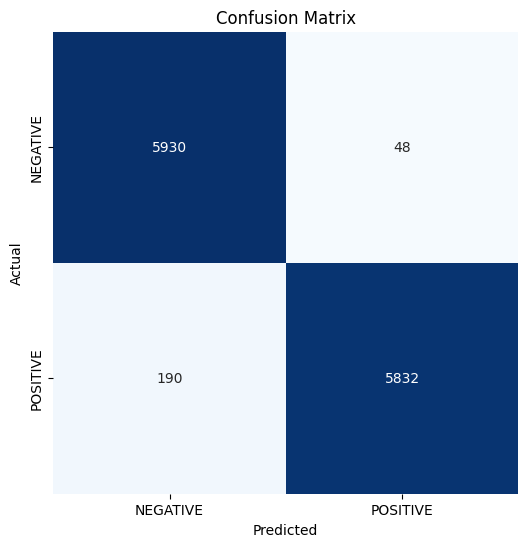


Calculating Classification Report...
              precision    recall  f1-score   support

    NEGATIVE     0.9690    0.9920    0.9803      5978
    POSITIVE     0.9918    0.9684    0.9800      6022

    accuracy                         0.9802     12000
   macro avg     0.9804    0.9802    0.9802     12000
weighted avg     0.9804    0.9802    0.9802     12000

--- Evaluation Complete ---


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import math

print("--- Generating Evaluation Metrics for Model 1 ---")

# 1. Reset the test_data generator to ensure it starts from the beginning
test_data.reset()

# 2. Get predictions from the model
print("Generating predictions...")
# Calculate the number of steps to cover all test samples exactly once
steps_for_predict = math.ceil(test_data.n / test_data.batch_size)
raw_predictions = model.predict(test_data, steps=steps_for_predict)

# Process predictions:
# raw_predictions might be slightly longer than test_data.n if steps * batch_size > test_data.n
# So, we take only the first test_data.n predictions.
y_pred = np.squeeze((raw_predictions[:test_data.n] >= 0.5).astype(int))
print(f"Generated {len(y_pred)} predictions for {test_data.n} samples.")

# 3. Get true labels
# For a Keras DataFrameIterator, .labels provides the true labels.
# If shuffle=True was used when creating test_data (default for flow_from_dataframe),
# test_data.labels holds the labels in the order determined by that initial shuffle.
# model.predict() on a reset generator will also follow this same initial shuffle order.
true_labels = test_data.labels[:test_data.n] # Ensure we only take up to N labels

print(f"Number of true labels: {len(true_labels)}")

# Double-check lengths (should match if steps and slicing are correct)
if len(y_pred) != len(true_labels):
    print("Warning: Mismatch between the number of predictions and true labels. Metrics might be affected.")
    # Fallback if there's still a mismatch:
    min_len = min(len(y_pred), len(true_labels))
    y_pred = y_pred[:min_len]
    true_labels = true_labels[:min_len]
    print(f"Adjusted lengths to {min_len}.")


# 4. Calculate and Display Confusion Matrix
print("\nCalculating Confusion Matrix...")
cm = confusion_matrix(true_labels, y_pred)

# Dynamically get target names for display
# test_data.class_indices is a dict like {'NEGATIVE': 0, 'POSITIVE': 1}
idx_to_class = {v: k for k, v in test_data.class_indices.items()}
target_display_names = [idx_to_class[i] for i in sorted(idx_to_class.keys())] # e.g., ['NEGATIVE', 'POSITIVE']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False,
            xticklabels=target_display_names, yticklabels=target_display_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 5. Calculate and Display Classification Report
print("\nCalculating Classification Report...")
# Use the same target_display_names for the report
print(classification_report(true_labels, y_pred, target_names=target_display_names, digits=4))

print("--- Evaluation Complete ---")

Sample raw predictions (probabilities for POSITIVE class):
[[0.01084805]
 [0.9999682 ]
 [0.00663154]
 [0.00816903]
 [0.00834438]
 [1.        ]
 [0.3116955 ]
 [0.00785622]
 [0.0091822 ]
 [0.00485253]
 [0.9999968 ]
 [0.99999714]
 [0.00395005]
 [1.        ]
 [0.02152079]
 [0.99992347]
 [0.02406043]
 [0.10957014]
 [1.        ]
 [1.        ]]


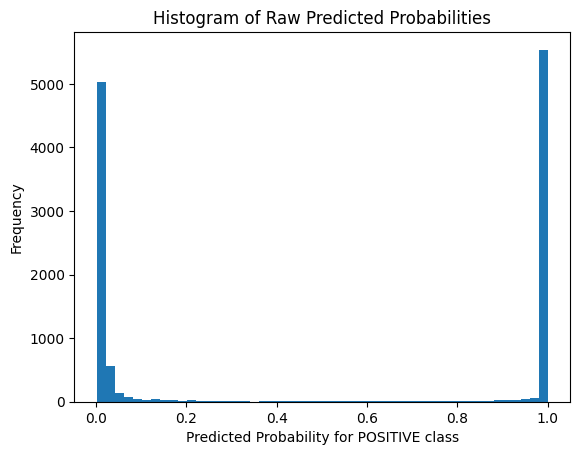

In [ ]:

print("Sample raw predictions (probabilities for POSITIVE class):")
print(raw_predictions[:20]) # Shows the first 20 probabilities

import matplotlib.pyplot as plt
plt.hist(raw_predictions[:test_data.n], bins=50) # Use [:test_data.n] to avoid issues if raw_predictions is longer
plt.title("Histogram of Raw Predicted Probabilities")
plt.xlabel("Predicted Probability for POSITIVE class")
plt.ylabel("Frequency")
plt.show()